# Exploratory Data Analysis

Looking at the Kaggle dataset [Realistic Loan Approval Dataset | US & Canada](https://www.kaggle.com/datasets/parthpatel2130/realistic-loan-approval-dataset-us-and-canada/data) for its major features, and preparing it for classification.


## Description of dataset from Author

1️⃣ Real-World Approval Logic The dataset implements actual banking criteria:

 - DTI ratio > 50% = automatic rejection
 - Defaults on file = instant reject
 - Credit score bands match real lending thresholds
 - Employment verification for loans ≥$20K


2️⃣ Realistic Correlations

 - Higher income → Better credit scores
 - Older applicants → Longer credit history
 - Students → Lower income, special treatment for small loans
 - Loan intent affects approval (Education best, Debt Consolidation worst)


3️⃣ Product-Specific Rules

 - Cards: More lenient, higher limits
 - Personal Loans: Standard criteria, up to $100K
 - Line of Credit: Capped at $50K, manual review for high amounts


4️⃣ Edge Cases Included

 - Young applicants (age 18) building first credit
 - Students with thin credit files
 - Self-employed with variable income
 - High debt-to-income ratios
 - Multiple delinquencies


## Exploration Steps

1. Fetch Data and Store Artifact
2. Initial Visual and Tabular Assessment
3. Data Cleaning
4. Model Training and Selection
5. Model Assessment Against Baseline

In [ ]:
# Python 3 Standard Library
import os
from pathlib import Path
import re

# if you are re-running this on your system, you'll probably need to change this path to match where you are storing these files
PROJECT_ROOT_PATH = Path(f"{os.environ['USERPROFILE']}\\OneDrive\\Education\\WGU\\Capstone")

# making sure I'm in the right directory for EDA, need to be in root
if not re.match(r'.*Capstone$', os.getcwd()):
    os.chdir(PROJECT_ROOT_PATH)

# Data Science Modules
## Data Analytics and Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Machine Learning
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, fbeta_score, precision_score, accuracy_score
from sklearn.dummy import DummyClassifier

# Experiment Tracking
import wandb

# Custom modules
from src.utilities import new_logger, save_atomic

# Setting Pandas DataFrame options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

For the purposes of turning this project into a reproducible MLOps pipeline, I will be tracking the exploratory analysis using Weights & Biases.

This will include the notebook itself at this point - the actual data artifacts will be added during the MLFlow pipeline run.

In [101]:
# TODO: start W&B run to log notebook

This is a module-wide logger that is tied to this notebook. During operation, it may also trigger writes to `logs/utils/src.utilities.log` when using `src.utilities` functions.

In [4]:
logger = new_logger("eda.data_exploration", "logs")

### 1. Fetch Data and Store Artifact

This dataset was downloaded locally as a CSV file. It will be saved in Weights & Biases (experiment tracking) as a Parquet file for the added benefit of storing the metadata.

I'm being careful to use `Path` in order to create absolute references to files on disk. This will help prevent odd behavior for relative references when run on other operating systems.

In [102]:
# Fetch local dataset
data_path = Path('data/Loan_approval_data_2025.csv').resolve()
logger.info(f"Attempting to fetch data from '{data_path}'")

loan_appr_df = pd.read_csv(data_path)
logger.info(f"Successfully created DataFrame {loan_appr_df.shape}")

In [ ]:
# saving original in Parquet format for submission as artifact
orig_data_path_parquet = save_atomic(loan_appr_df, Path("data/loan_approval_data_2025.orig.parquet"), fmt="parquet")

### 2. Initial Visual and Tabular Assessment

#### Tabular Assessment (Directed and Non-Directed)

During this part of the process I am looking for multiple issues common to datasets from the Internet:
- Missing data
- Malformed data/typos
- Improper data ranges
- Improper data types

The first section deals with looking for missing data and dtypes, then we move on to looking at the correlations between numeric features as well as their distributions.

In [6]:
loan_appr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              50000 non-null  object 
 1   age                      50000 non-null  int64  
 2   occupation_status        50000 non-null  object 
 3   years_employed           50000 non-null  float64
 4   annual_income            50000 non-null  int64  
 5   credit_score             50000 non-null  int64  
 6   credit_history_years     50000 non-null  float64
 7   savings_assets           50000 non-null  int64  
 8   current_debt             50000 non-null  int64  
 9   defaults_on_file         50000 non-null  int64  
 10  delinquencies_last_2yrs  50000 non-null  int64  
 11  derogatory_marks         50000 non-null  int64  
 12  product_type             50000 non-null  object 
 13  loan_intent              50000 non-null  object 
 14  loan_amount           

There doesn't seem to be any missing data. This makes sense because this is a synthetic dataset, though it is based on realistic business rules surrounding approving or denying loans.

In [103]:
loan_appr_df.isna().sum()

customer_id                0
age                        0
occupation_status          0
years_employed             0
annual_income              0
credit_score               0
credit_history_years       0
savings_assets             0
current_debt               0
defaults_on_file           0
delinquencies_last_2yrs    0
derogatory_marks           0
product_type               0
loan_intent                0
loan_amount                0
interest_rate              0
debt_to_income_ratio       0
loan_to_income_ratio       0
payment_to_income_ratio    0
loan_status                0
dtype: int64

Now I'll look for duplicated rows within the dataset. Since this is synthetically generated data, I don't expect to see any duplicated rows. This will exclude the `customer_id` column since that column will make each row unique by default.

A value of 0 indicates that there are not duplicated rows.

In [108]:
loan_appr_df.drop(columns=['customer_id']).duplicated().sum()

np.int64(0)

In [7]:
loan_appr_df.describe()

,age,years_employed,annual_income,credit_score,credit_history_years,savings_assets,current_debt,defaults_on_file,delinquencies_last_2yrs,derogatory_marks,loan_amount,interest_rate,debt_to_income_ratio,loan_to_income_ratio,payment_to_income_ratio,loan_status
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,34.957060,7.454868,50062.892040,643.614820,8.168274,3595.619400,14290.442220,0.053480,0.55464,0.147640,33041.874000,15.498591,0.285724,0.701999,0.233995,0.550460
std,11.118603,7.612097,32630.501014,64.731518,7.207552,13232.399398,13243.757493,0.224991,0.84505,0.412996,26116.185102,4.067942,0.159787,0.465788,0.155268,0.497452
min,18.000000,0.000000,15000.000000,348.000000,0.000000,0.000000,60.000000,0.000000,0.00000,0.000000,500.000000,6.000000,0.002000,0.008000,0.003000,0.000000
25%,26.000000,1.300000,27280.500000,600.000000,2.000000,130.000000,5581.000000,0.000000,0.00000,0.000000,12300.000000,12.180000,0.161000,0.333000,0.111000,0.000000
50%,35.000000,4.900000,41607.500000,643.000000,6.100000,568.000000,10385.000000,0.000000,0.00000,0.000000,26100.000000,15.440000,0.265000,0.622000,0.207000,1.000000
75%,43.000000,11.400000,62723.250000,687.000000,12.600000,2271.000000,18449.250000,0.000000,1.00000,0.000000,48500.000000,18.870000,0.389000,1.010250,0.337000,1.000000
max,70.000000,39.900000,250000.000000,850.000000,30.000000,300000.000000,163344.000000,1.000000,9.00000,4.000000,100000.000000,23.000000,0.800000,2.001000,0.667000,1.000000


The basic descriptive statistics for each numeric columns look reasonable based on my knowledge of each of these columns.

Now I'll do a non-directed assessment of the head, tail, and a random sample of rows within the dataset. This is an attempt to look for consistency throughout the data. I am also looking for situations where the columns should be joined, melted, or otherwise engineered to produce a better analysis.

In [89]:
loan_appr_df.head(25)

,customer_id,age,occupation_status,years_employed,annual_income,credit_score,credit_history_years,savings_assets,current_debt,defaults_on_file,delinquencies_last_2yrs,derogatory_marks,product_type,loan_intent,loan_amount,interest_rate,debt_to_income_ratio,loan_to_income_ratio,payment_to_income_ratio,loan_status
0,CUST100000,40,Employed,17.2,25579,692,5.3,895,10820,0,0,0,Credit Card,Business,600,17.02,0.423,0.023,0.008,1
1,CUST100001,33,Employed,7.3,43087,627,3.5,169,16550,0,1,0,Personal Loan,Home Improvement,53300,14.10,0.384,1.237,0.412,0
2,CUST100002,42,Student,1.1,20840,689,8.4,17,7852,0,0,0,Credit Card,Debt Consolidation,2100,18.33,0.377,0.101,0.034,1
3,CUST100003,53,Student,0.5,29147,692,9.8,1480,11603,0,1,0,Credit Card,Business,2900,18.74,0.398,0.099,0.033,1
4,CUST100004,32,Employed,12.5,63657,630,7.2,209,12424,0,0,0,Personal Loan,Education,99600,13.92,0.195,1.565,0.522,1
5,CUST100005,32,Employed,13.4,32015,570,7.3,253,1120,0,0,2,Credit Card,Personal,37000,22.92,0.035,1.156,0.385,0
6,CUST100006,53,Employed,22.9,44989,674,11.1,19667,19298,0,0,0,Personal Loan,Home Improvement,45600,11.02,0.429,1.014,0.338,1
7,CUST100007,44,Self-Employed,4.2,80603,625,18.5,830,38382,0,0,0,Credit Card,Personal,51700,19.42,0.476,0.641,0.214,1
8,CUST100008,29,Employed,5.9,28416,569,2.6,1334,22668,1,2,0,Credit Card,Education,33800,22.72,0.798,1.189,0.396,0
9,CUST100009,41,Employed,7.0,70717,638,21.5,1578,21394,0,1,0,Credit Card,Personal,70000,19.35,0.303,0.990,0.330,1


In [90]:
loan_appr_df.tail(25)

,customer_id,age,occupation_status,years_employed,annual_income,credit_score,credit_history_years,savings_assets,current_debt,defaults_on_file,delinquencies_last_2yrs,derogatory_marks,product_type,loan_intent,loan_amount,interest_rate,debt_to_income_ratio,loan_to_income_ratio,payment_to_income_ratio,loan_status
49975,CUST149975,21,Self-Employed,1.0,68454,552,2.3,1371,24545,0,3,1,Personal Loan,Debt Consolidation,100000,16.41,0.359,1.461,0.487,0
49976,CUST149976,38,Employed,10.3,27469,691,8.5,2151,18801,0,1,0,Personal Loan,Business,9600,12.16,0.684,0.349,0.116,0
49977,CUST149977,32,Employed,3.9,23132,560,13.9,112,8077,0,1,0,Personal Loan,Personal,23700,15.81,0.349,1.025,0.342,1
49978,CUST149978,53,Student,0.8,15000,591,27.2,509,3882,0,0,0,Credit Card,Home Improvement,900,21.34,0.259,0.060,0.020,1
49979,CUST149979,18,Student,1.2,26627,546,0.8,18,1634,0,2,0,Line of Credit,Business,13800,14.54,0.061,0.518,0.173,0
49980,CUST149980,35,Employed,10.5,28836,524,0.5,36,2558,0,0,0,Credit Card,Medical,32900,22.62,0.089,1.141,0.380,0
49981,CUST149981,40,Self-Employed,16.2,36357,601,19.4,3526,22029,0,1,0,Credit Card,Personal,31600,20.29,0.606,0.869,0.290,0
49982,CUST149982,45,Student,0.1,27554,698,9.6,665,1429,0,0,0,Personal Loan,Personal,45600,12.32,0.052,1.655,0.552,1
49983,CUST149983,36,Employed,6.2,67472,763,10.6,264,5643,0,0,0,Credit Card,Personal,68600,14.10,0.084,1.017,0.339,1
49984,CUST149984,39,Self-Employed,4.8,113630,717,10.8,422,37982,0,0,0,Personal Loan,Debt Consolidation,92900,11.17,0.334,0.818,0.273,1


In [73]:
loan_appr_df.sample(25)

,customer_id,age,occupation_status,years_employed,annual_income,credit_score,credit_history_years,savings_assets,current_debt,defaults_on_file,delinquencies_last_2yrs,derogatory_marks,product_type,loan_intent,loan_amount,interest_rate,debt_to_income_ratio,loan_to_income_ratio,payment_to_income_ratio,loan_status
18253,CUST118253,37,Employed,12.2,49369,758,7.2,166,24640,0,0,0,Credit Card,Home Improvement,45100,15.16,0.499,0.914,0.305,1
39012,CUST139012,26,Self-Employed,1.2,89867,664,0.9,343,54604,0,0,0,Credit Card,Personal,30600,18.63,0.608,0.341,0.114,0
20709,CUST120709,30,Employed,0.1,28471,736,7.3,89,467,0,0,0,Credit Card,Education,12300,16.26,0.016,0.432,0.144,1
45166,CUST145166,30,Self-Employed,3.1,178914,577,3.1,5152,28078,0,0,0,Credit Card,Education,15300,22.27,0.157,0.086,0.029,1
36725,CUST136725,39,Employed,5.1,56933,556,12.4,831,12830,0,0,0,Line of Credit,Debt Consolidation,35200,13.59,0.225,0.618,0.206,0
30506,CUST130506,29,Employed,6.7,27942,531,10.1,1186,5457,0,3,1,Personal Loan,Home Improvement,53800,16.61,0.195,1.925,0.642,0
22838,CUST122838,66,Employed,4.3,33006,762,27.4,204236,8132,0,0,0,Personal Loan,Home Improvement,43300,8.71,0.246,1.312,0.437,1
36347,CUST136347,51,Employed,24.1,45275,720,25.9,1513,19924,0,0,1,Personal Loan,Home Improvement,74700,9.60,0.440,1.650,0.550,1
16660,CUST116660,18,Self-Employed,1.0,54462,582,0.6,487,10622,0,0,0,Credit Card,Home Improvement,4900,22.27,0.195,0.090,0.030,1
12125,CUST112125,27,Employed,0.7,50949,609,7.8,5210,27891,0,0,0,Line of Credit,Debt Consolidation,37100,12.63,0.547,0.728,0.243,0


#### Exploratory Visualizations

First, I isolate the columns into their various types. Since there are so few `object` columns, I will create that column grouping first, and then use it to narrow down to the numeric types. For ease of analysis, I will make two separate numeric groupings - one with the target variable `loan_status` and one without.

Then, the `obj_cols` group will be examined for repeated values - this indicate a good candidate for a categorical column.

Next, the `num_cols` will be analyzed using a correlation heatmap to look at relationships among variables. [I may also look at various slices of the data to see how relationships may change??]

Finally, I will take a look at the distributions of the `num_cols` group to get a sense of how normal each distribution is, or whether it has unique characteristics such as discrete values, or bimodality.

In [114]:
# Categorical columns, currently represented as `object` (string) dtypes
obj_cols = [col for col in loan_appr_df.dtypes[loan_appr_df.dtypes == 'object'].index if col != 'customer_id']

# all numerical columns including the `loan_status` target variable
num_cols_with_target = loan_appr_df.drop(columns=obj_cols).drop(columns=['customer_id']).columns.values

# all numerical columns excluding the `loan_status` target variable
num_cols = loan_appr_df.drop(columns=obj_cols).drop(columns=['customer_id', 'loan_status']).columns.values

#### Categorical Feature Exploration

Moving on to the object features, looking at the current possible values.

In [ ]:
for col in obj_cols:
    print(f"{loan_appr_df[col].value_counts()}\n")

occupation_status
Employed         34971
Self-Employed    10179
Student           4850
Name: count, dtype: int64

product_type
Credit Card       22455
Personal Loan     17523
Line of Credit    10022
Name: count, dtype: int64

loan_intent
Personal              12429
Education             10134
Medical                7598
Business               7469
Home Improvement       7453
Debt Consolidation     4917
Name: count, dtype: int64



Based on what we can see above, these columns are all good candidates for becoming categorical. Let's look at the distributions of each feature to see if they make sense.

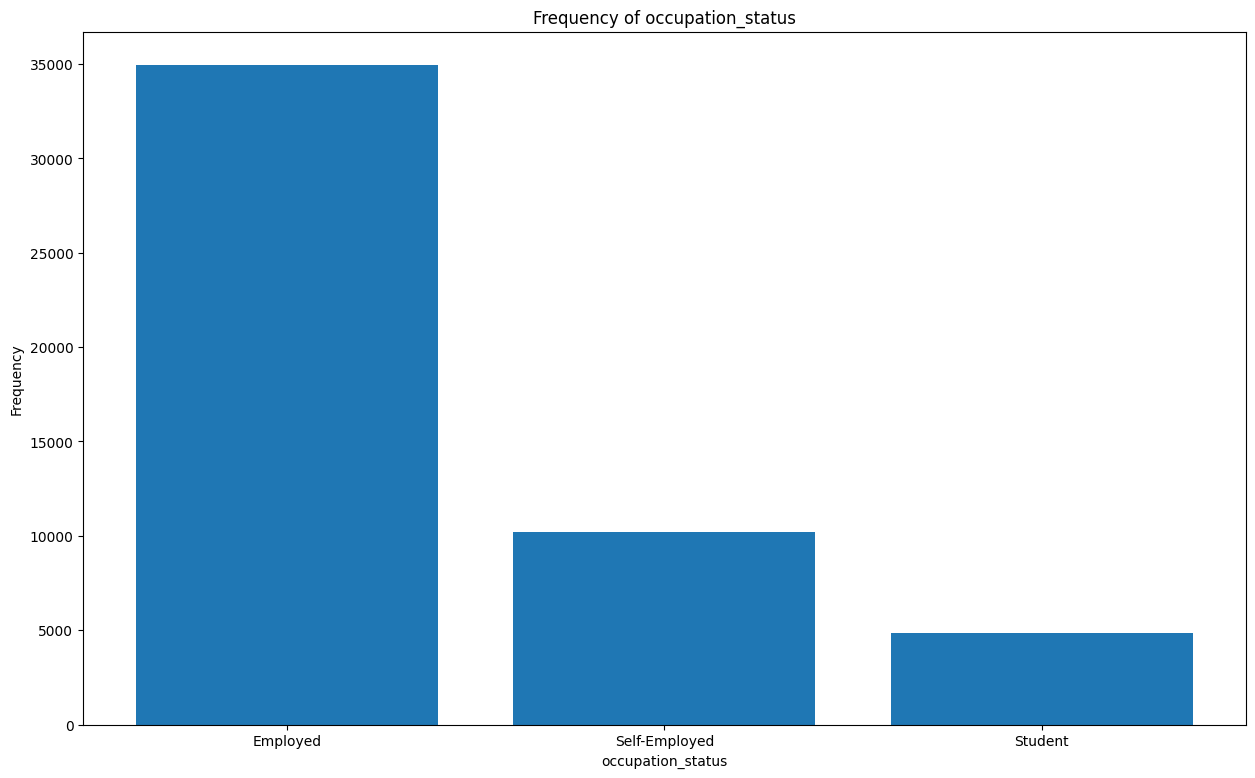

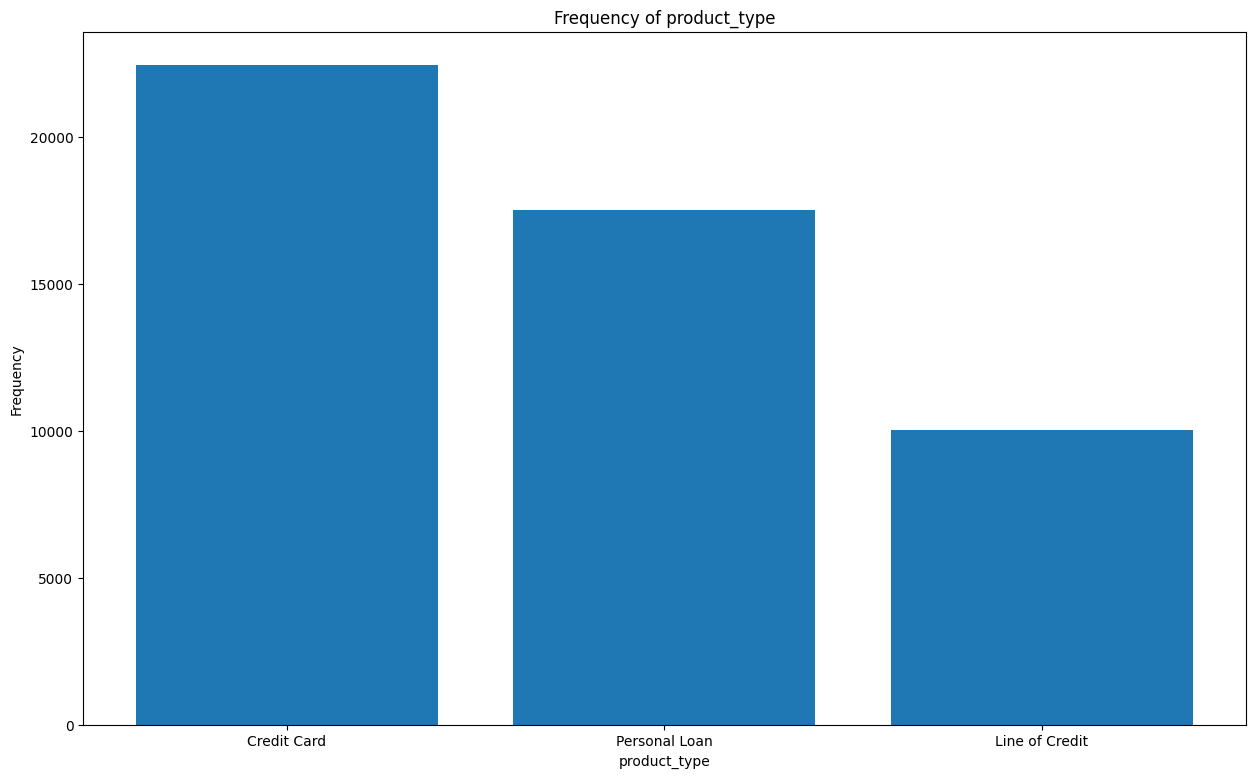

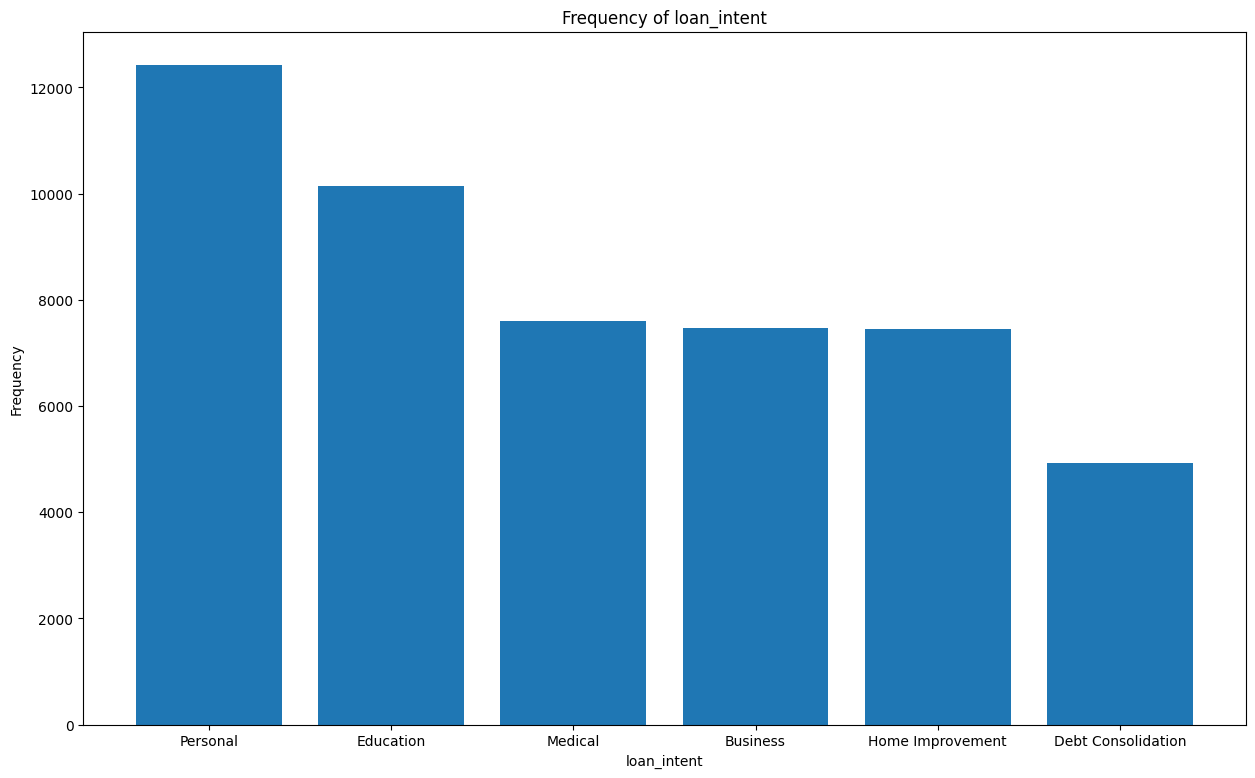

In [ ]:
for col in obj_cols:
    val_counts = loan_appr_df[col].value_counts()
    fig, ax = plt.subplots(figsize=(15,9))
    ax.bar(val_counts.index.values, val_counts.values)
    ax.set_xlabel(val_counts.index.name)
    ax.set_ylabel("Frequency")
    ax.set_title(f"Frequency of {val_counts.index.name}")

These categories seem like they make sense, and no changes are needed. This is expected from a synthetic dataset.

#### Numerical Feature Exploration

In [ ]:
# create a correlation matrix with all of the numeric values
correlation_matrix = loan_appr_df[num_cols_with_target].corr()

Text(0.5, 1.0, 'Loan Application: Numeric Variables Correlation Heatmap')

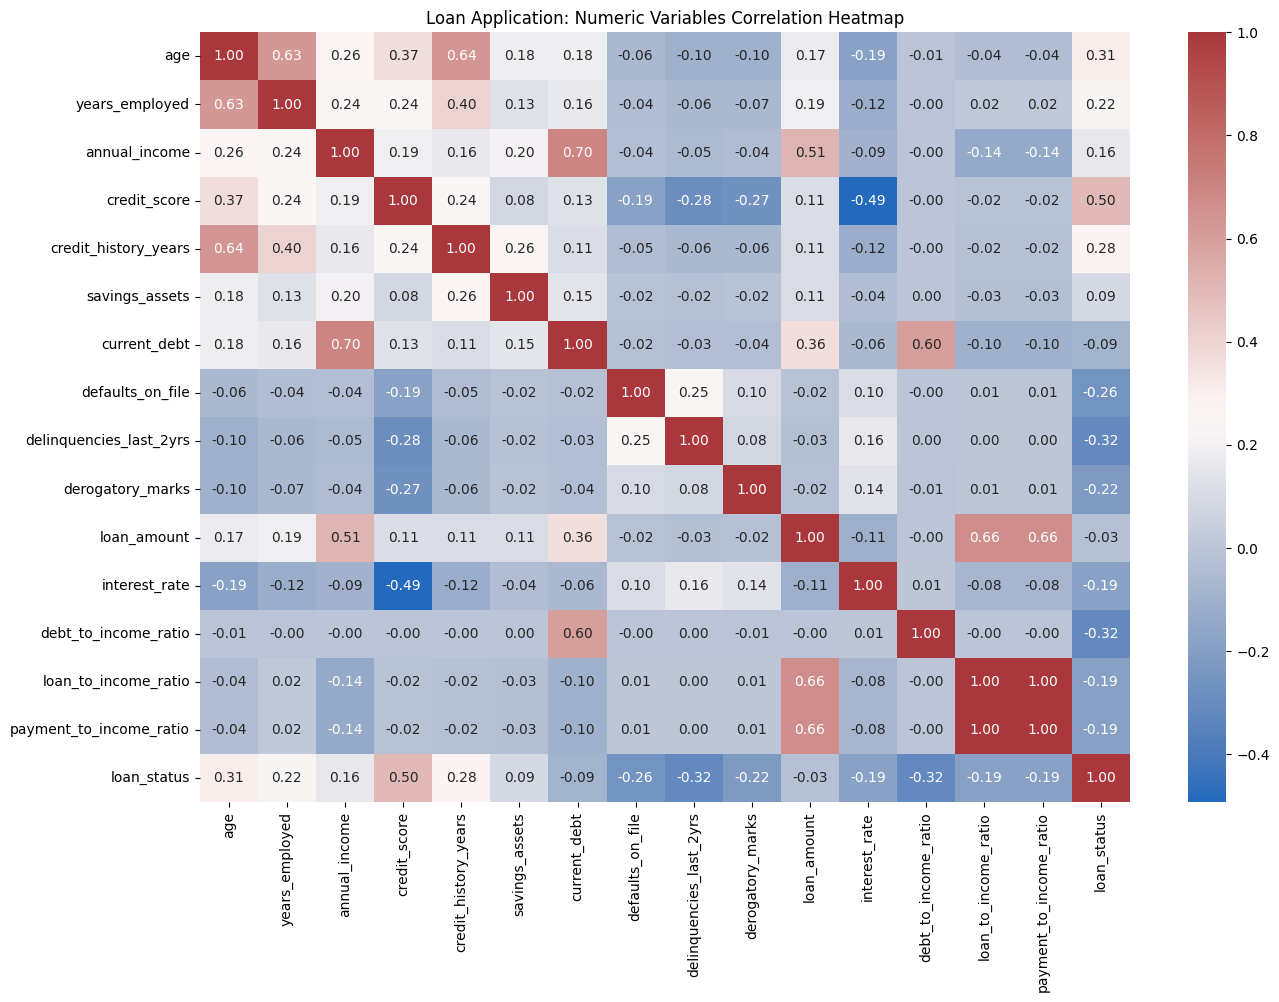

In [100]:
# create a Seaborn heatmap showing all of the correlation values
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, annot=True, cmap="vlag", fmt=".2f")
plt.title("Loan Application: Numeric Variables Correlation Heatmap")

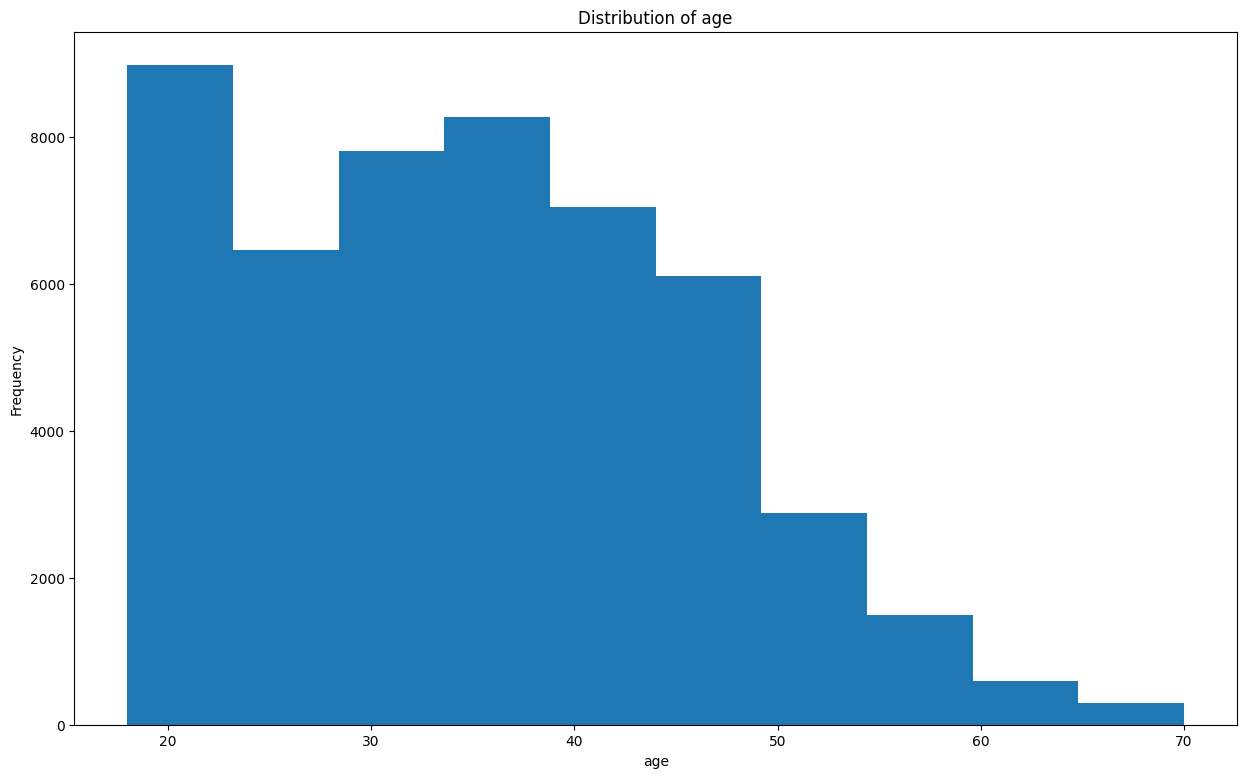

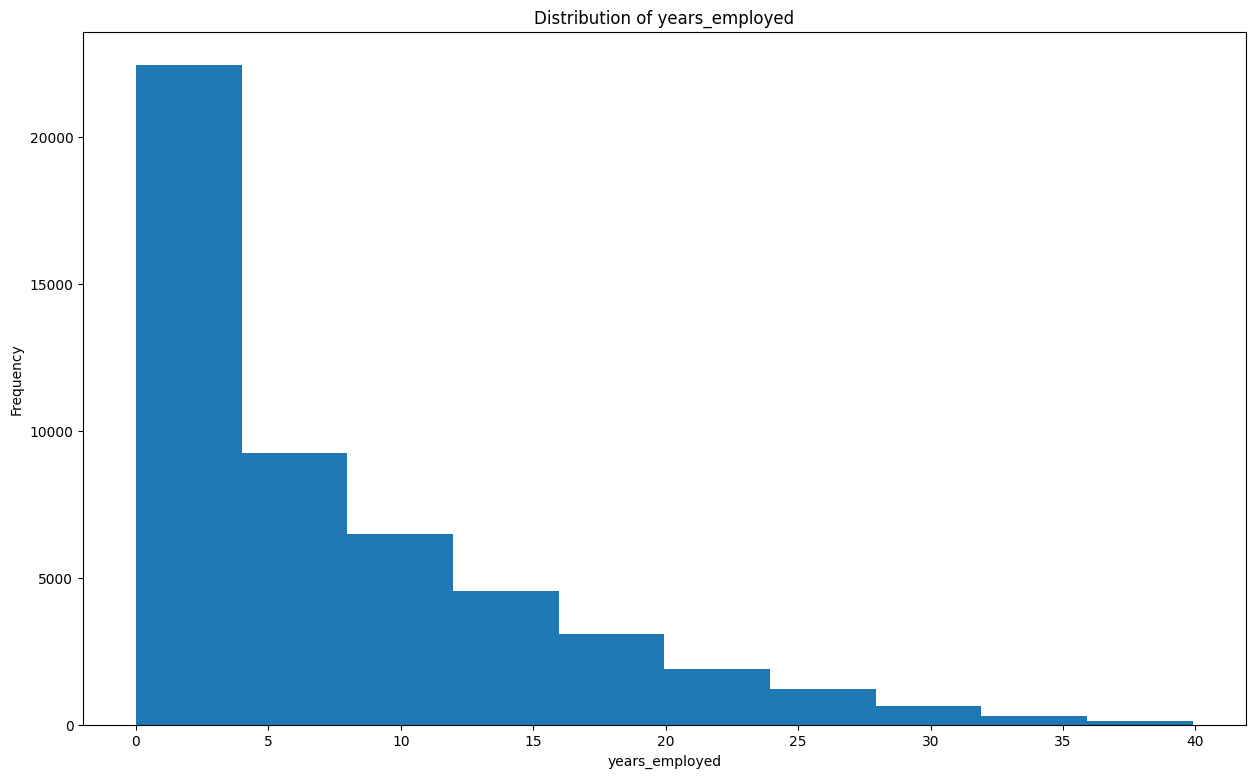

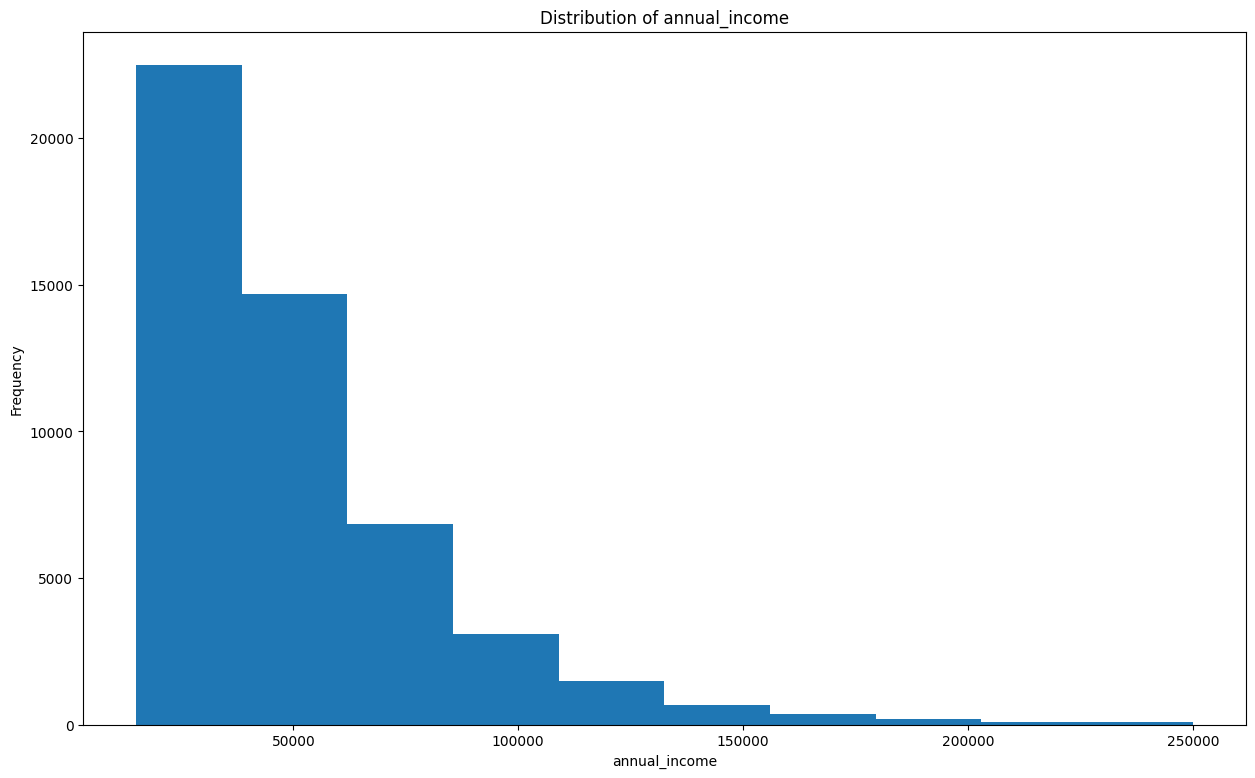

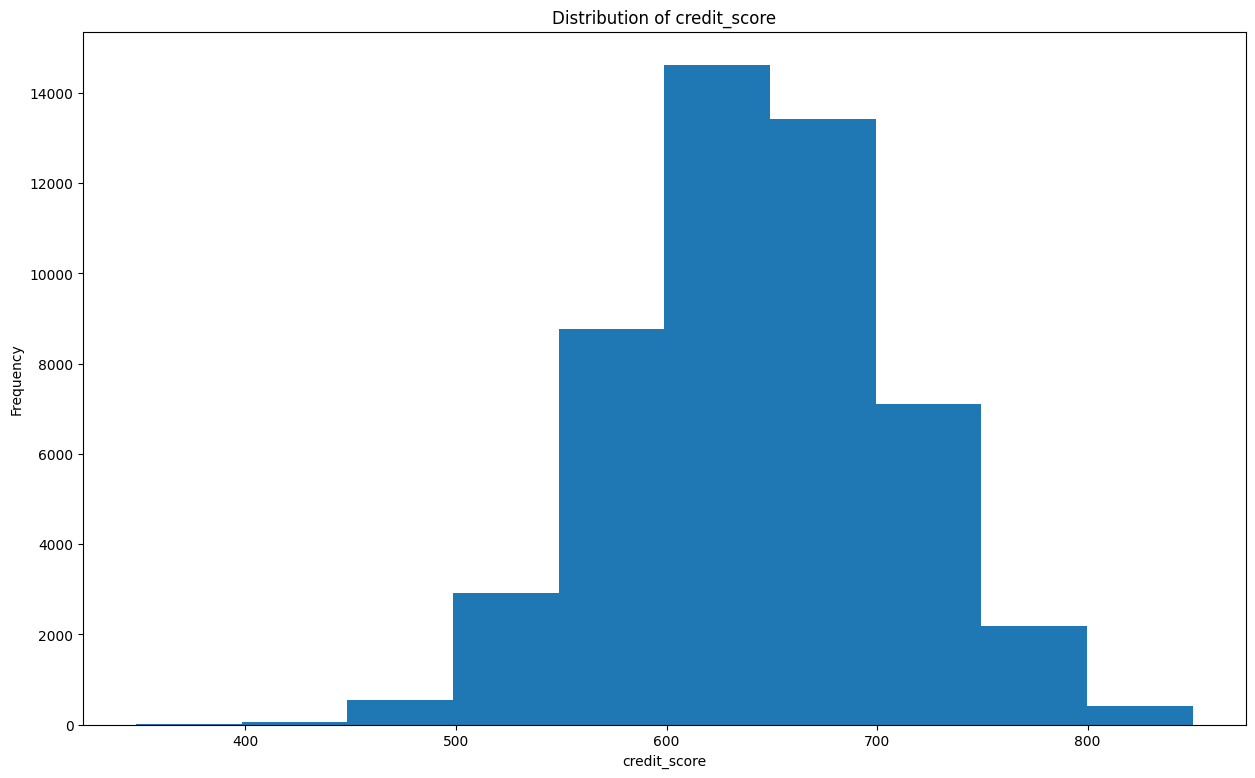

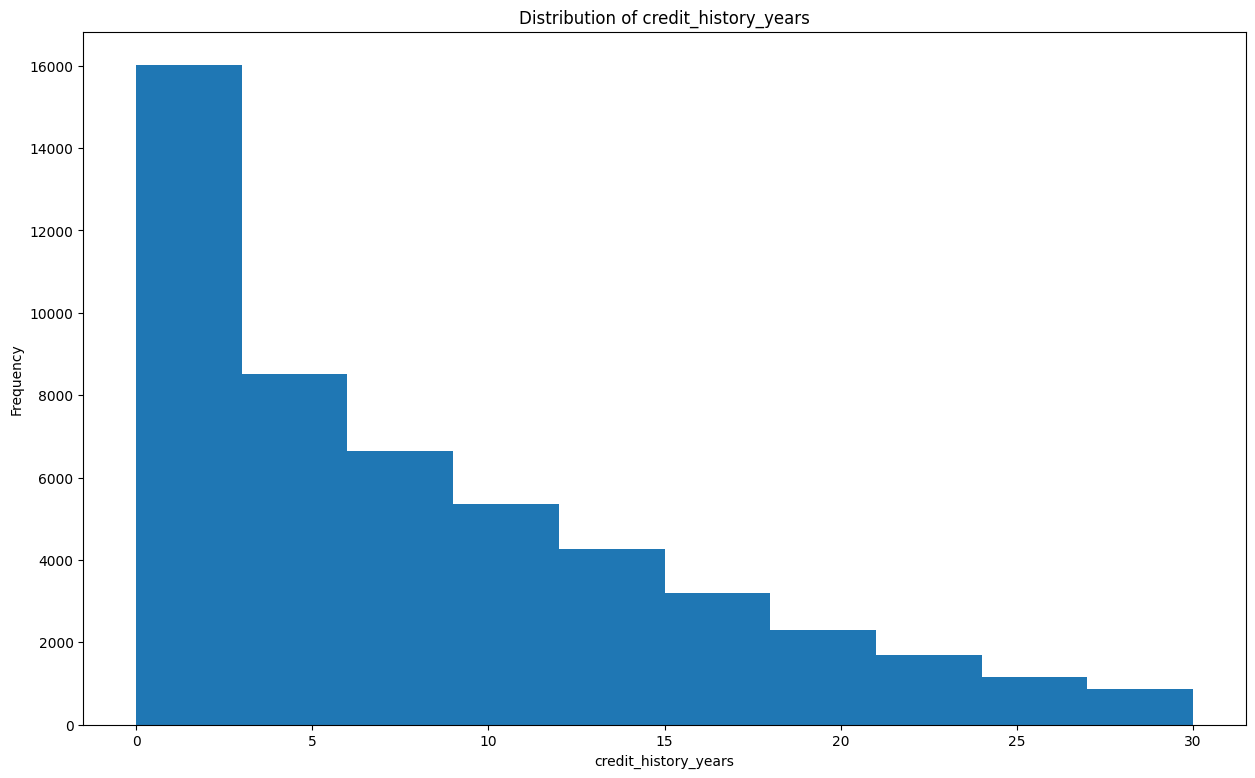

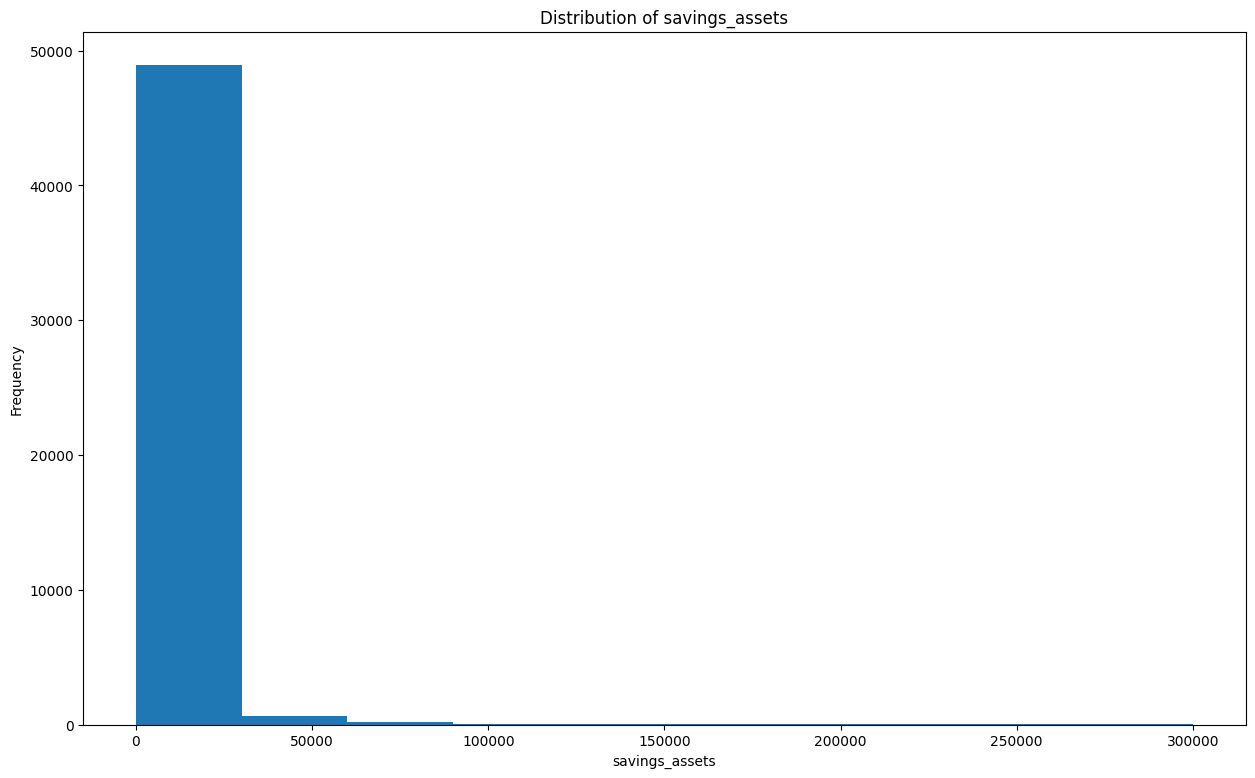

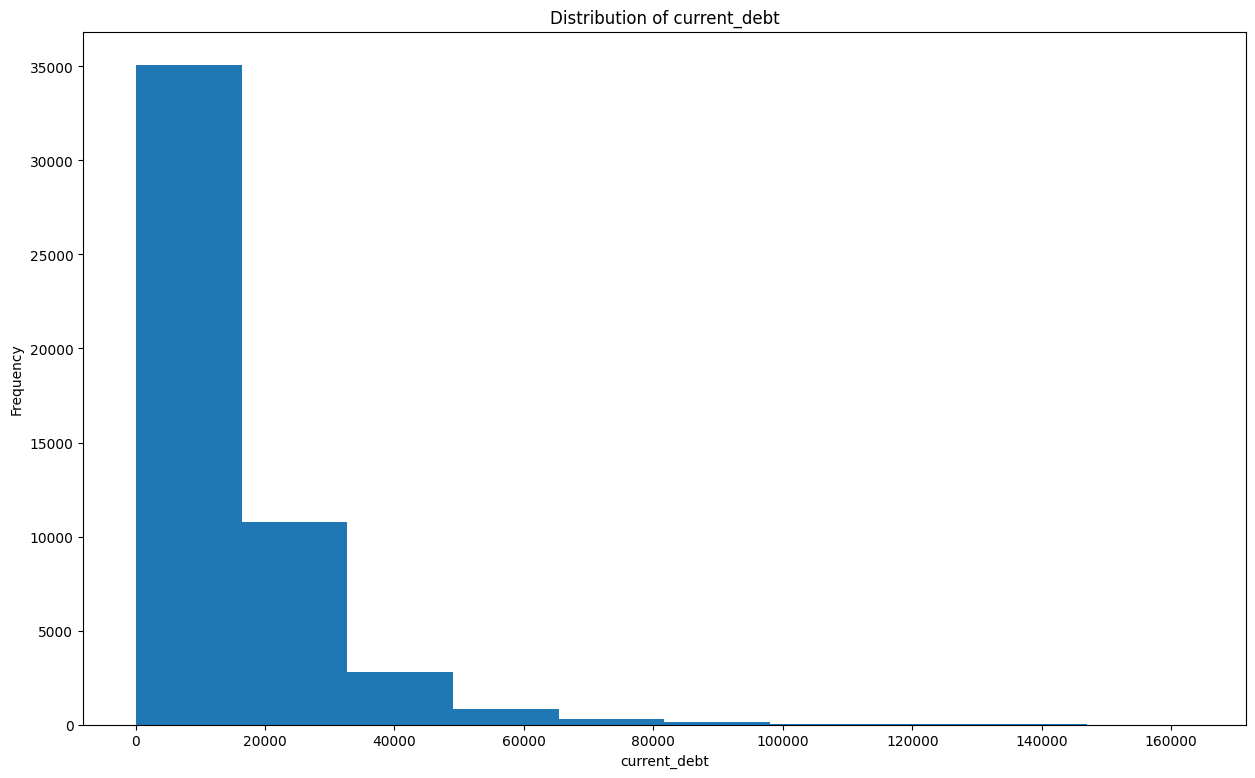

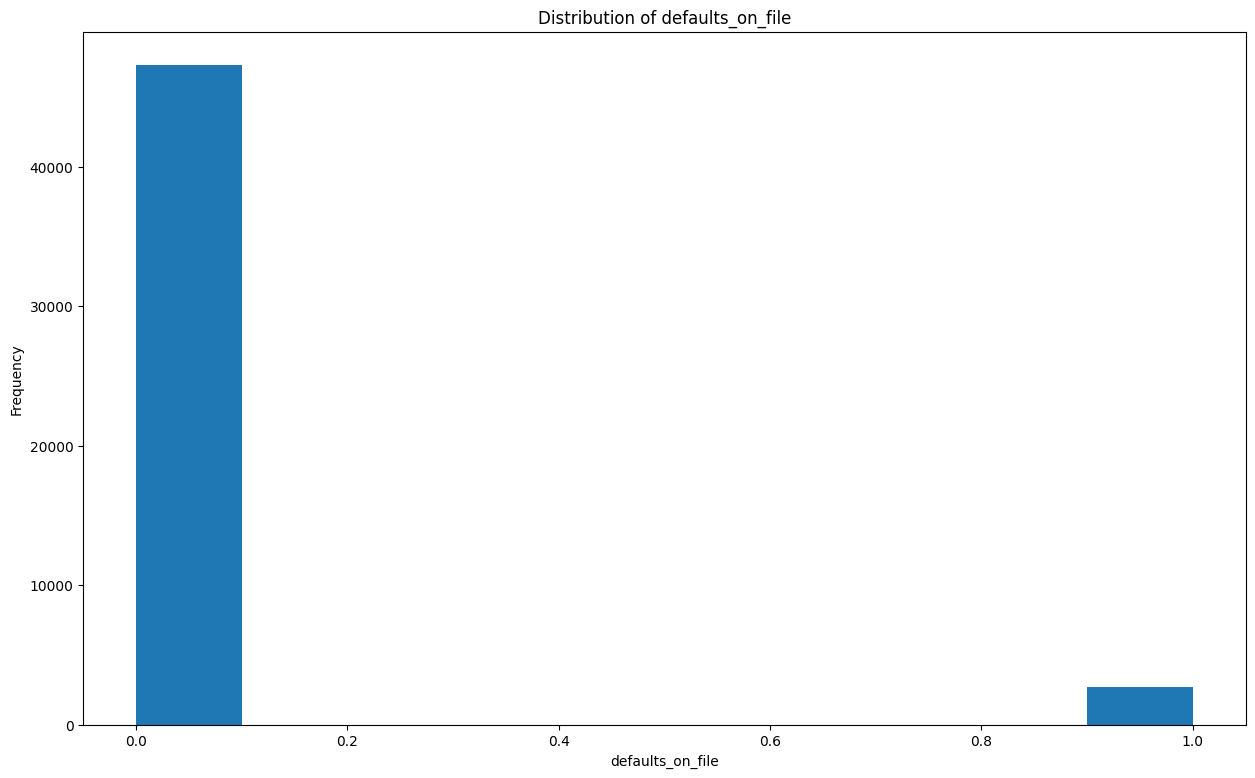

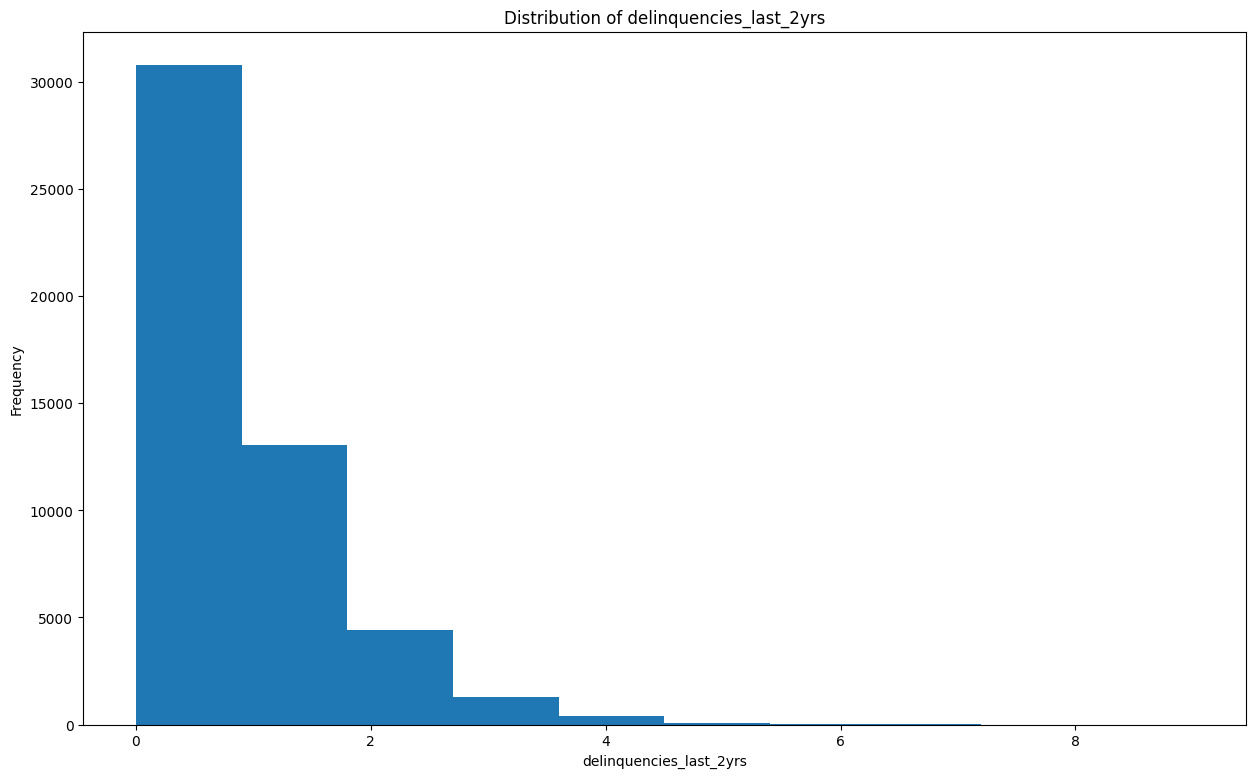

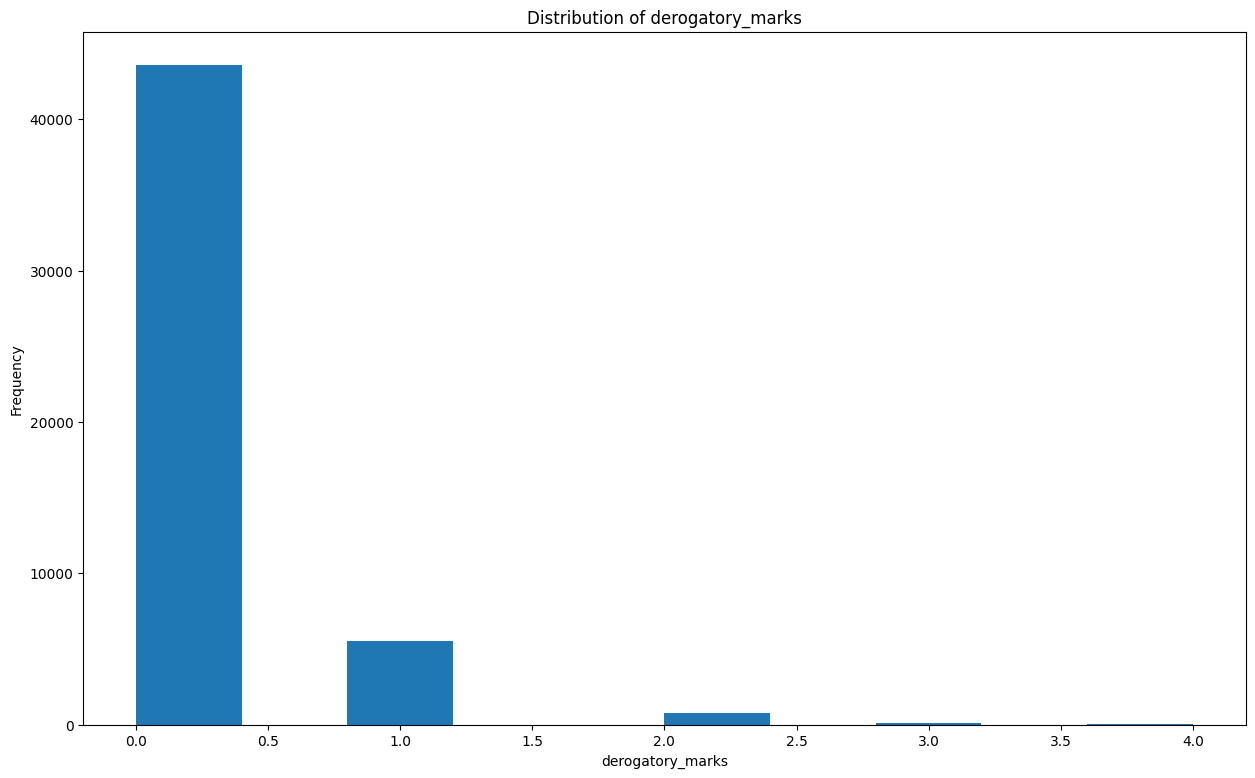

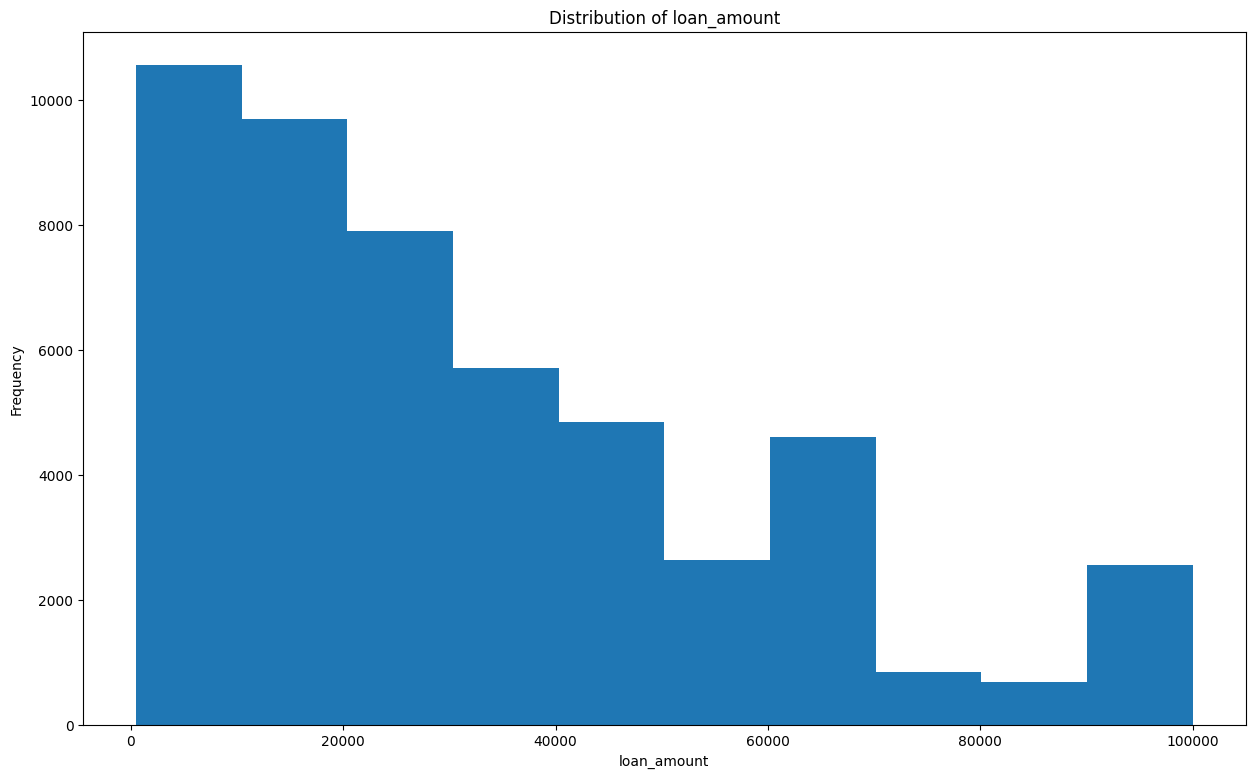

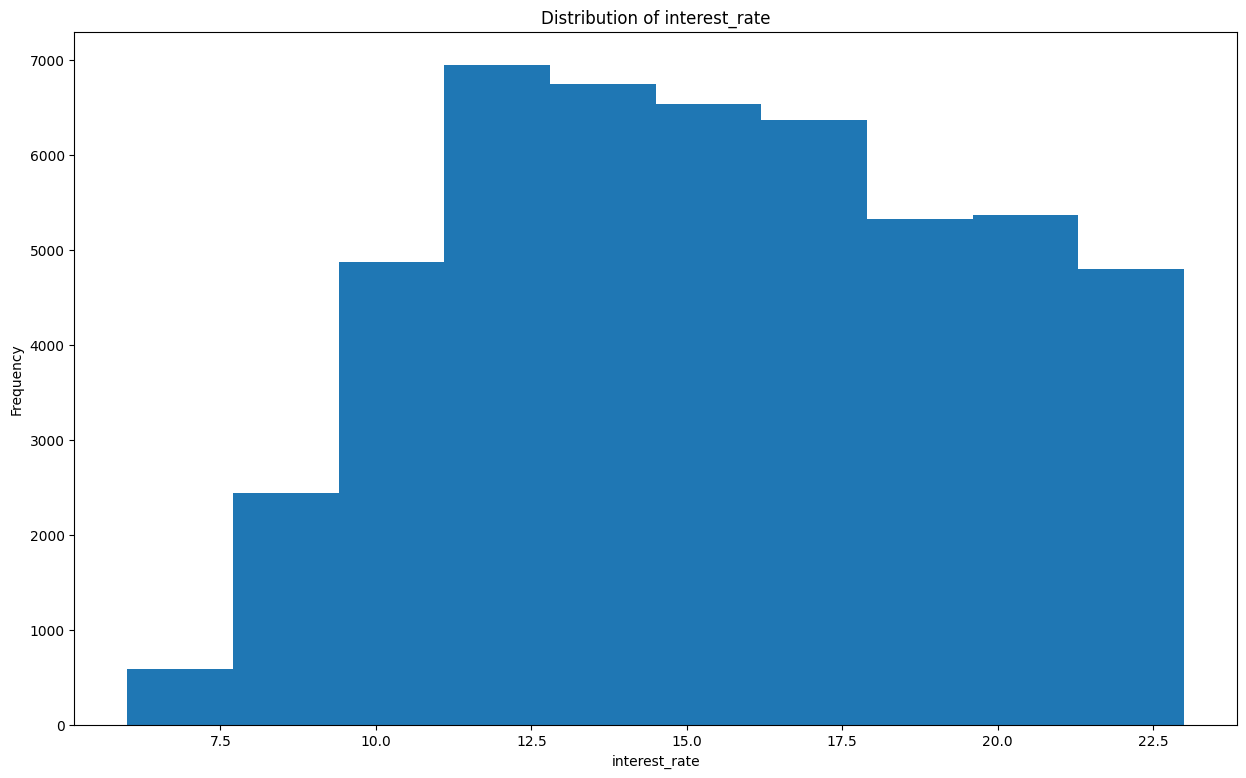

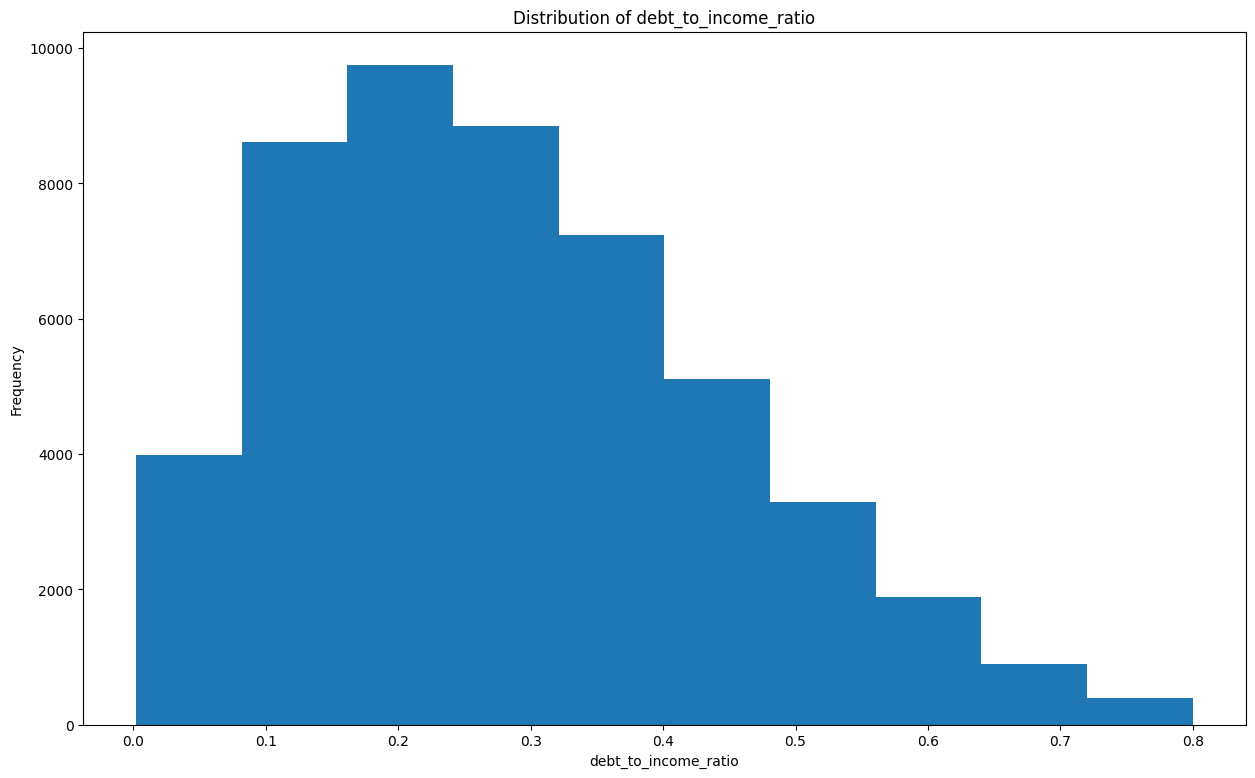

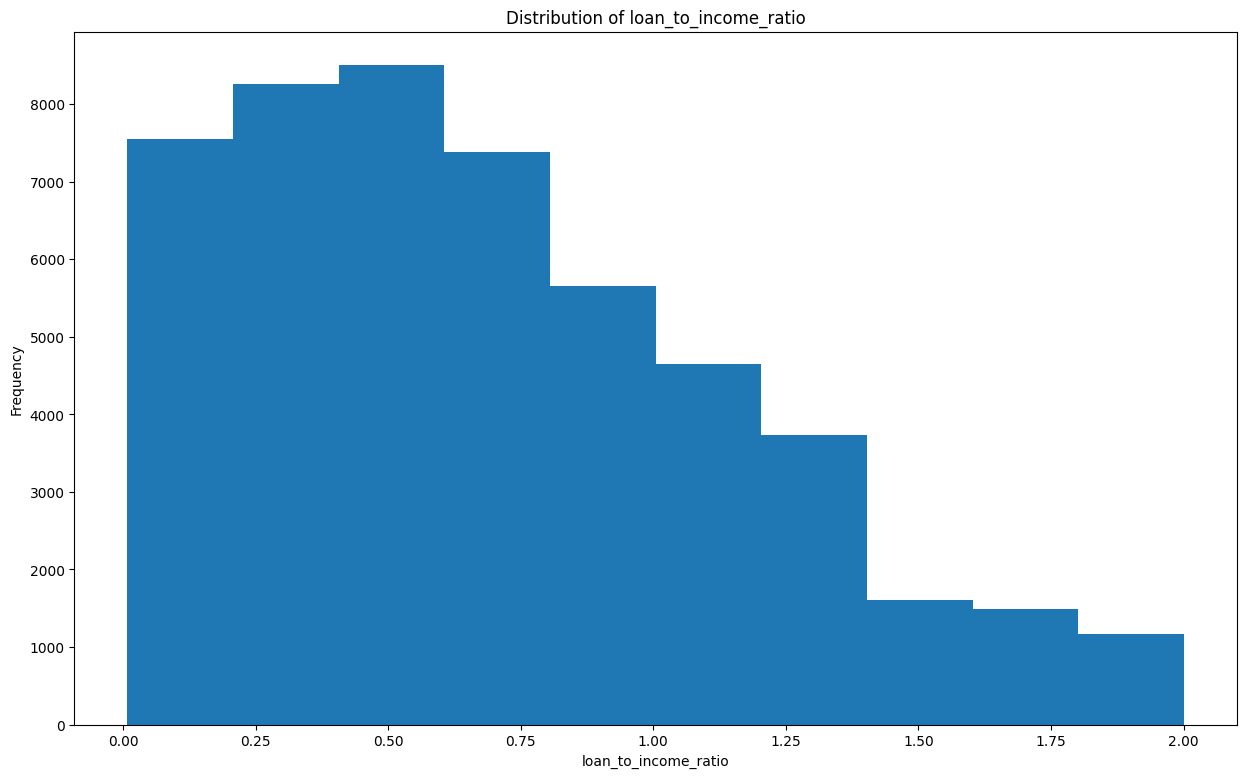

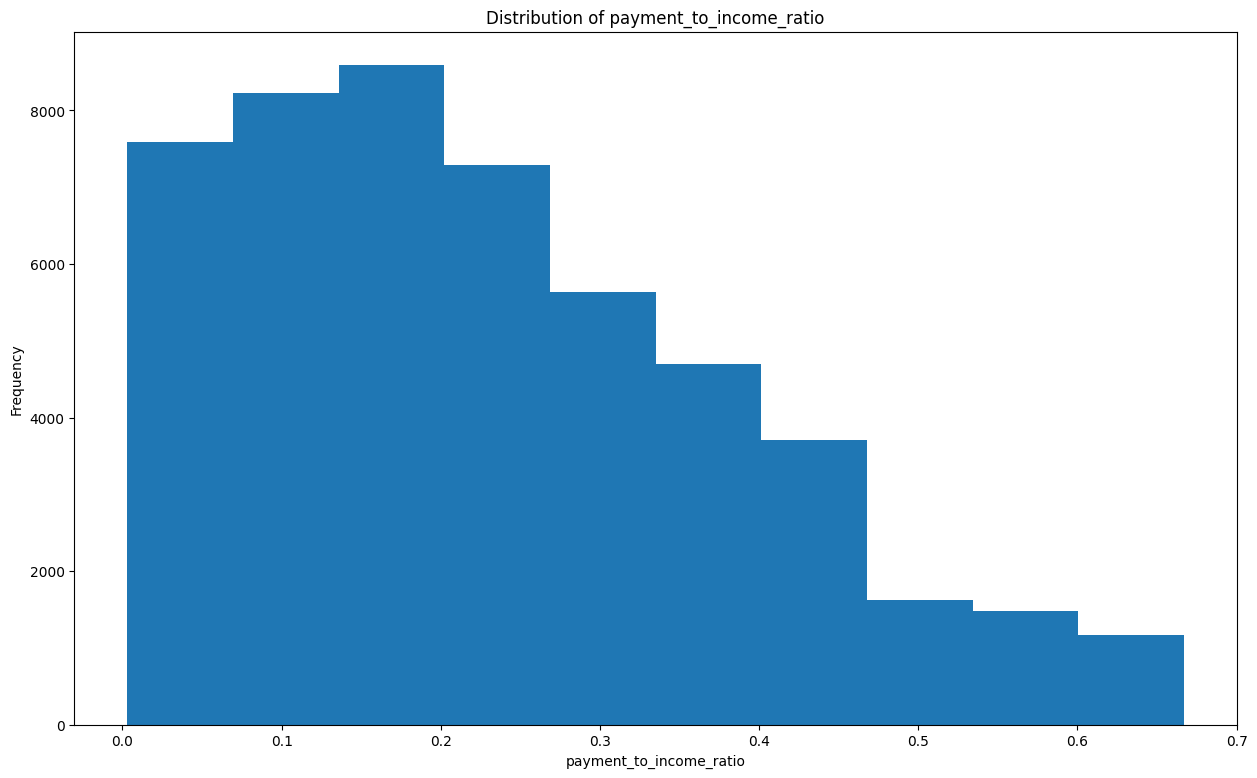

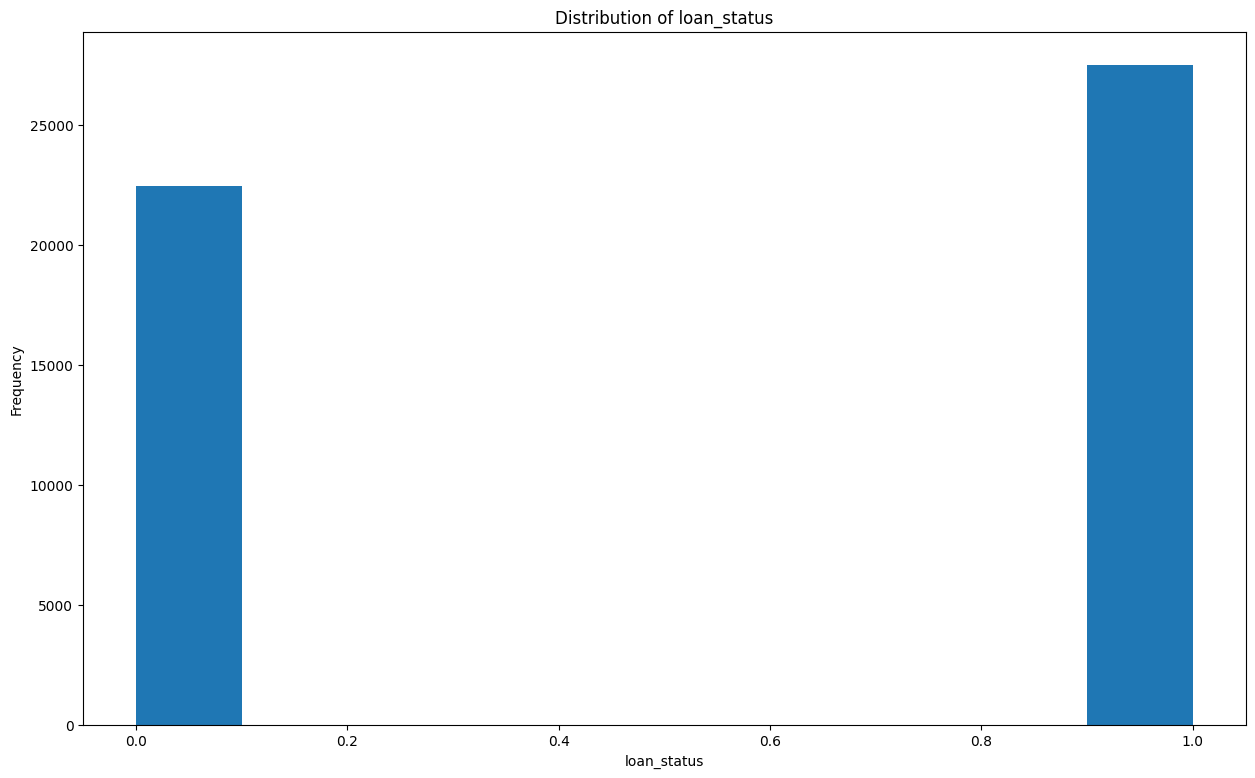

In [29]:
for col in num_cols:
    fig, ax = plt.subplots(figsize=(15,9))
    n, bins, patches = ax.hist(loan_appr_df[col])
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.set_title(f"Distribution of {col}")

These distributions look appropriate for each category, no major changes will be required. There is no case of "normal" distributions, which for looking at human populations is expected. The only "bimodal" feature seen is `loan_status` which doesn't really count since it's the binary response variable (the classification we're making).

Other non-continuous distributions are for `derogatory_marks`, `defaults_on_file`, and `delinquencies_last_2_years` are expected as these are discrete variables.

### 3. Data Cleaning

Based on what I can see in this dataset, there is barely any cleaning that must take place. Instead, there simply needs to be a pipeline to create a `OneHotEncoder` for the categorical columns and `StandardScaler` for the numeric columns for use in a Random Forest Classifier.

At this point, just dropping the customer ID column because it isn't useful in classification. This may have been able to be done earlier in the process as well. An alternative treatment is to use this column as the index, rather than the existing non-semantic index.

In addition, I will adjust the dtype of the object columns to be categorical for more efficient storage of data moving forward, and to solidify the idea that they are categories that will benefit from One-Hot Encoding before training the `RandomForestClassifier` model.

In [ ]:
# remove the unique Customer_ID identifier
loan_appr_wip = loan_appr_df.drop(columns=['customer_id'])

In [ ]:
# make each object feature a category feature instead
for col in obj_cols:
    loan_appr_wip[col] = loan_appr_wip[col].astype('category')

In [ ]:
# save clean dataset as Parquet, for logging to W&B later
data_path = save_atomic(loan_appr_wip, Path("data/loan_approval_data_2025.clean.parquet"), fmt="parquet")

Now that cleaning is complete, let's perform a quick look at the clean DataFrame to make sure that the dtypes are correct and we still have no null values.

In [ ]:
loan_appr_wip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   age                      50000 non-null  int64   
 1   occupation_status        50000 non-null  category
 2   years_employed           50000 non-null  float64 
 3   annual_income            50000 non-null  int64   
 4   credit_score             50000 non-null  int64   
 5   credit_history_years     50000 non-null  float64 
 6   savings_assets           50000 non-null  int64   
 7   current_debt             50000 non-null  int64   
 8   defaults_on_file         50000 non-null  int64   
 9   delinquencies_last_2yrs  50000 non-null  int64   
 10  derogatory_marks         50000 non-null  int64   
 11  product_type             50000 non-null  category
 12  loan_intent              50000 non-null  category
 13  loan_amount              50000 non-null  int64   
 14  intere

### 4. Model Training and Selection

This section of the notebook provides the basis for the model training and selection process that will be implemented as a part of the completed MLOps pipeline.

First, I will split the X and y variables. Then, I will generate the training and testing sets. One alternative that may produce a better model is to perform cross-validation, switching up the training and testing sets to take full advantage of all of our available data. TODO: look into implementing cross-validation in this case, how would I treat the metrics and the model in that case?

Next, I will create a machine learning pipeline that includes the preprocessing steps for both the categorical (`OneHotEncoder`) and numeric (`StandardScaler`) variables. This ensures that the trained pipeline can be used for both training and inference as the same steps are being performed in both instances (provided the DataFrame columns are similar).

Finally, that machine learning pipeline will be trained using the `GridSearchCV` method for hyperparameter tuning. This will allow me to narrow in on which parameters are best for this scenario to reach the optimal hyperparameters for this dataset.

In [ ]:
# split the data into X and y sets
y = loan_appr_wip.pop('loan_status')
X = loan_appr_wip

In [ ]:
# Split data into training and testing data
# TODO: replace this simple split with K-fold cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7292025)

In [59]:
# Building a column transformer out of OneHotEncoder and StandardScaler
logger.info("Starting inference training pipeline")
cat_preproc = OneHotEncoder()
logger.debug(f"Created OneHotEncoder for columns {obj_cols}")
num_preproc = StandardScaler()
logger.debug(f"Created StandardScaler for columns {num_cols}")

preproc = ColumnTransformer(
    transformers=[
        ("cat_transform", cat_preproc, obj_cols),
        ("num_transform", num_preproc, num_cols)
    ],
    remainder='drop'
)
logger.debug("Created ColumnTransformer for categorical and numerical preprocessing with all above columns. Any other columns will be dropped.")

pipeline = Pipeline([
    ('preprocessing', preproc), # Preprocessing step
    ('clf', RandomForestClassifier()) # Model step
])
logger.debug("Pipeline created with RandomForestClassifier as the inference model.")

scorer = make_scorer(fbeta_score, beta=0.5)
logger.debug("F-Beta scorer in use, with beta=0.5 for higher precision model")

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'clf__n_estimators': [10**x for x in range(0,4)],
    'clf__max_features': [0.3, 0.5, 'sqrt', None],
    'clf__max_depth': [x for x in range(1,6)],
    'clf__min_samples_split': [x*2 for x in range(1,6)]
}
logger.debug(f"Using GridSearch parameters: {param_grid}")

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, scoring=scorer, verbose=2, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Output the best parameters and test accuracy
logger.info(f"Best Parameters: {grid_search.best_params_}")
logger.info(f"Test Accuracy: {grid_search.score(X_test, y_test)}")

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


#### 5. Model Assessment Against Baseline

In [134]:
# Creating the dummy classifier baselines using multiple strategies

dummy_strategies = {
    "most_frequent": DummyClassifier(strategy="most_frequent"),
    "stratified": DummyClassifier(strategy='stratified', random_state=72925),
    "uniform": DummyClassifier(strategy="uniform", random_state=72925),
    "constant_0": DummyClassifier(strategy="constant", constant=0)
}

# evaluate and fit each dummy strategy
results_data = {}

for name, clf in dummy_strategies.items():
    clf.fit(X_train, y_train)
    y_pred_dummy = clf.predict(X_test)
    results_data[name] = [
        accuracy_score(y_test, y_pred_dummy),
        precision_score(y_test, y_pred_dummy, zero_division=0),
        fbeta_score(y_test, y_pred_dummy, beta=0.5, zero_division=0)
    ]

In [135]:
# Creating the actual RandomForestClassifier model with the optimized hyperparameters
rfclf_pipeline = grid_search.best_estimator_
y_pred_real = rfclf_pipeline.predict(X_test)
results_data["RandomForest"] = [
    accuracy_score(y_test, y_pred_real),
    precision_score(y_test, y_pred_real, zero_division=0),
    fbeta_score(y_test, y_pred_real, beta=0.5, zero_division=0)
]

In [136]:
results = pd.DataFrame(
    results_data,
    index=["Accuracy", "Precision", "F-Beta (0.5)"],
)

logger.info(f"\n{results}\n")

<Axes: title={'center': 'Baseline Strategies vs Random Forest Performance'}>

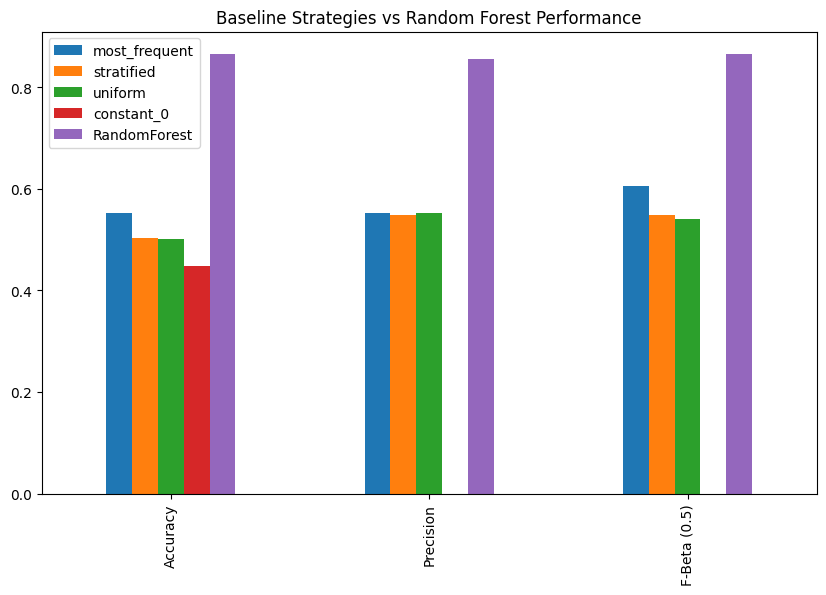

In [137]:
results.plot(kind='bar', figsize=(10,6), title="Baseline Strategies vs Random Forest Performance")